In this project, I decided to work on semantic segmantation of blood vessels images. 

The data that I've used comes from DRIVE dataset. It is a small dataset of 40 images. I collected the data from https://drive.grand-challenge.org/ website. The data consists of binary segmentation masks for half of the images, to make it possible to validate the model. For this project, I am using only this half first, to make sure my idea for solving the task works as expected, and then, I will perform the inference on the other half to check if my soltion works. The task is quite challenging, due to limited amount of labelled training data. I've been using Google Collab notebook to make it possible to use free GPU, that makes training process much faster.

In [ ]:
# PyTorch
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.utils import make_grid

# Data manipulations
import numpy as np
from PIL import Image
import cv2
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt

# helpers
import glob
import os
import copy
import time
import csv

# dataloader
from data_loader import ApplyClaheColor
from data_loader import Denoise
from data_loader import Resize
from data_loader import ToTensor
from data_loader import Normalize
from data_loader import SegmentationDataset

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from Model.unet import UNet

data_dir = 'Training Data/training_data'

img_ch=3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(3,1)
model.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

After preparing the data, one need to implement class representing the dataset and corresponding dataloaders. It is a convention of PyTorch, deep learning framework that I'm using.

One thing that is worth noticing, is that I had to add some black padding around images. It is because, I am using U-Net - like architecture with learnable visual attention blocks, and spatial dimensions of signal coming from skip connections and their corresponging feature maps must fit together. That is why the pictures after padding have size (592, 576) - they can be downsampled using max pooling 4 times (the dimensions are possible to divide by 4).

The picture that helps to understand the U-Net architecture is given below. It is a encoder-decoder architecture, that means that input image is first downsampled using max pooling. This process produces feature maps, that is semantic features coming from imput image. Then, the feature maps are upsampled again, to classify each pixel in the image. To make this process more accurate, authors of the architecture decided to use skip connections: signal from feature maps is combined with input image. It helps to decide precisely, which picture should be considered positive class (in this case: blood vessel) and which one should be marked as a background.

The picture's source is the U-Net paper.

![alt text](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

Recently, the field of Deep Learning is evolving extremely fast. New ideas and architectures are proposed frequently. One of them, that helped to improve NLP is attention. It is an idea that we can try to make our model focus on certain parts of the incoming signal (in case of text: sequences of words, in case of images: matrices with their digital representation). Computer Vision community, inspired by the work of their colleagues, have developed an idea of visual attention. For example the paper "Learn to pay attention" by Jetley et al describes the usage of learnable attention gate, that is additional blocks that gather signals from different layers of the network and learn where useful information from the image is. The prediction is made by concatenating the output from the attention blocks, and not by making use of the last layer of the network directly. The image from the article that describes the idea is given below: ![alt text](https://miro.medium.com/max/616/0*8r63L3yR66SVBgJR)

This idea was futher developed for semantic segmentation tasks by Oktay et al in the article "Attention U-Net: Learning Where to Look for the Pancreas". The difference is that attention blocks are now learning to filter signal from skip connections by estimating the information coming from them by comparing it with features from feature maps.
![alt text](https://miro.medium.com/max/780/1*PdYEf-OuUWkRsm2Lfrmy6A.png)


I decided to use this idea for my dataset, because it might work quite well, and also I would learn a lot.

I have prepared several transformations to be applied on the images. I've used random flip as augmentation technique. I am also using CLAHE (Contrast Limiting Adaptive Histogram Equalization) nad Bilateral filter to improve the quality of images: CLAHE preforms histogram equalization in a smart way. I included Bilateral filter because I've noticed that after CLAHE the pictures are a little bit noisy. I decided to use bilateral filter instead of median filter because it keeps the edges sharp, what is crucial in segmentation task.

In [ ]:

def get_data_loaders(data_dir, image_folder='training_data/img', mask_folder='training_data/label', batch_size=4):
    
    data_transforms = {
        'training': transforms.Compose([ApplyClaheColor(), Denoise(), Resize((320, 320), (320, 320)), ToTensor(), Normalize()]),
        'test': transforms.Compose([ApplyClaheColor(), Denoise(), Resize((320, 320), (320, 320)),ToTensor(), Normalize()]),
    }
    
    image_datasets = {x: SegmentationDataset(root_dir=data_dir,
                                             transform=data_transforms[x],
                                             image_folder=image_folder,
                                             mask_folder=mask_folder,
                                             subset=x)
                      for x in ['training', 'test']}
    
    data_loaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0)
                    for x in ['training', 'test']}
    
    return data_loaders


def plot_batch_from_dataloader(dataloaders, batch_size):
    """

    :param dataloaders: dataset dataloaders
    :param batch_size: size of the batch to plot
    :return: void
    """
    batch = next(iter(dataloaders['training']))

    for i in range(batch_size):

        np_img = batch['image'][i].numpy()
        np_mask = batch['mask'][i].numpy()

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(np.transpose(np_img, (1, 2, 0)))
        ax[1].imshow(np.squeeze(np.transpose(np_mask, (1, 2, 0))), cmap='gray')
        plt.show()


def myimshow(img, unnormalize=False):
    """

    :param img: tensor of images, first dimension is number of images in the batch
    :param unnormalize: whenever to unnormalize the image before plotting
    :return: void
    """
    if unnormalize:
        img = img * 255

    np_img = img.numpy()
    plt.imshow(np.transpose(np_img[0], (1, 2, 0)))
    plt.show()


def images_generator(path):
    for img_name in glob.glob(os.path.join(path, '*')):
        image = np.array(Image.open(img_name)).transpose(2, 0, 1)
        yield image

For segmenation task, Dice Coefficient is often used to measure performance of the models. I havn't used it as a loss function directly, because I read that training the model with such loss function is not always stable. I decided to use Focal loss, because it has this nice property that it focuses on imbalanced positive class. It was developed for object detection, but it can be used for segmenation too. In the dataset that I am using there is quite a big class imbalance - most of the pixels don't represent blood vessels.

The picture below help us understand Dice Coefficient intuitevely. It is a 2 * |AnB| / (|A| + |B|)

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1f/Intersection_of_sets_A_and_B.svg/1200px-Intersection_of_sets_A_and_B.svg.png)

The plot helped me understand the Focal Loss. It comes from the Focal Loss paper.
![alt text](https://miro.medium.com/max/1032/1*wLf0KMIzBsXPcxsN7yBrIA.png)

C:\Users\TSLab\Desktop\CCTV Camera Network


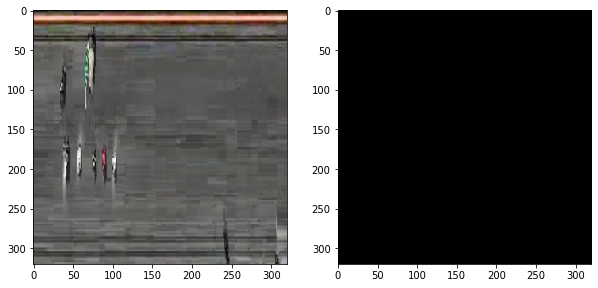

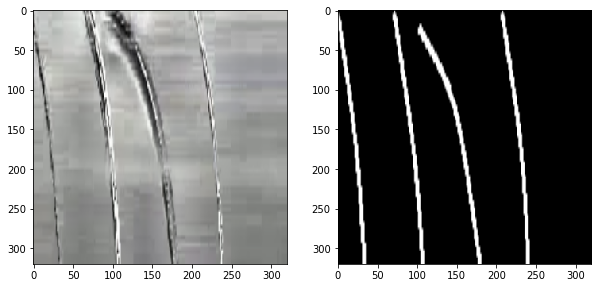

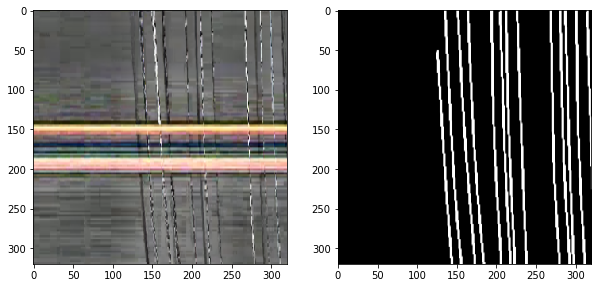

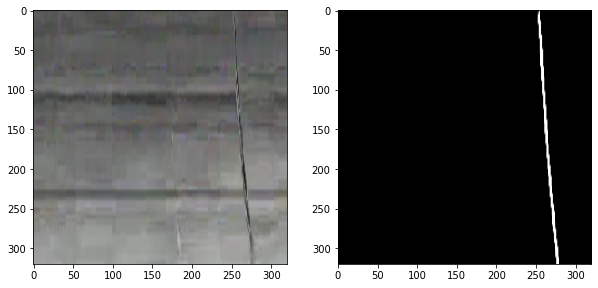

In [ ]:
data_dir = os.getcwd()
print(data_dir)
dataloaders = get_data_loaders(data_dir, batch_size=4)
plot_batch_from_dataloader(dataloaders, 4)

In [ ]:

def accuracy(y_true, y_pred):
    
    mask = np.zeros_like(y_pred)
    mask[y_pred >= 0.5] = 1

    compare = np.equal(mask, y_true)
    accuracy = np.sum(compare)

    return accuracy/len(y_pred.flatten())

def IoU(y_true, y_pred):
    # jaccard_score
    SMOOTH = 1e-6
    
    mask = np.zeros_like(y_pred)
    mask[y_pred >= 0.5] = 1
    
    intersection = np.logical_and(mask, y_true)
    union = np.logical_or(mask, y_true)
    
    iou_score = (np.sum(intersection) + SMOOTH) / (np.sum(union) + SMOOTH)
    return iou_score


def precision_and_recall(label_gt, label_pred, n_class):
    from sklearn.metrics import precision_score, recall_score
    assert len(label_gt) == len(label_pred)
    precision = np.zeros(n_class, dtype=np.float32)
    recall = np.zeros(n_class, dtype=np.float32)
    mask = np.zeros_like(label_pred)
    mask[label_pred >= 0.5] = 1
    
    img_A = np.array(label_gt, dtype=np.int64).flatten()
    img_B = np.array(mask, dtype=np.int64).flatten()
    precision[:] = precision_score(img_A, img_B, average=None, labels=range(n_class))
    recall[:] = recall_score(img_A, img_B, average=None, labels=range(n_class))

    return precision, recall
    
def dice_coeff(prediction, target):

    mask = np.zeros_like(prediction)
    mask[prediction >= 0.5] = 1

    inter = np.sum(mask * target)
    union = np.sum(mask) + np.sum(target)
    epsilon=1e-6
    result = np.mean(2 * inter / (union + epsilon))
    return result


class FocalLoss(nn.modules.loss._WeightedLoss):

    def __init__(self, gamma=0, size_average=None, ignore_index=-100,
                 reduce=None, balance_param=1.0):
        super(FocalLoss, self).__init__(size_average)
        self.gamma = gamma
        self.size_average = size_average
        self.ignore_index = ignore_index
        self.balance_param = balance_param

    def forward(self, input, target):
        
        # inputs and targets are assumed to be BatchxClasses
        assert len(input.shape) == len(target.shape)
        assert input.size(0) == target.size(0)
        assert input.size(1) == target.size(1)
           
        # compute the negative likelyhood
        logpt = - F.binary_cross_entropy_with_logits(input, target)
        pt = torch.exp(logpt)

        # compute the loss
        focal_loss = -( (1-pt)**self.gamma ) * logpt
        balanced_focal_loss = self.balance_param * focal_loss
        return balanced_focal_loss


There is quite some code needed to got everything working. In the training loop I'am tracking loss in each batch for each epoch, and save it for plotting the learning curve.

In [ ]:
## Model Training

model_name = "UNet"

since = time.time()
best_loss = 1e10
save_frq = 10000
ite_num = 0.0

## set up parameters ##
batch_size = 3
num_epochs = 100
Learning_Rate=1e-5
Weight_Decay=1e-4 # Weight for the weight decay loss function
MAX_ITERATION = int(800010) # Max  number of training iteration
NUM_CLASSES = 1 #Number of classes the model predict
best_loss = 1e10

track_history = []

dataloaders = get_data_loaders(data_dir, batch_size=batch_size)
optimizer=torch.optim.Adam(params=model.parameters(),lr=Learning_Rate,weight_decay=Weight_Decay)
criterion = FocalLoss(gamma=2)

# Use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

fieldnames = ['epoch', 'training_loss', 'test_loss', 'training_acc', 'test_acc', 'training_dice_coeff', 'test_dice_coeff']
train_epoch_losses = []
test_epoch_losses = []

train_epoch_accs = []
test_epoch_accs = []

saved_model_folder = os.path.join(os.getcwd(), 'saved_models')

if not os.path.exists(saved_model_folder):
    os.makedirs(saved_model_folder)
    
with open(f'log_{model_name}.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

for epoch in range(1, num_epochs + 1):

    print(f'Epoch {epoch}/{num_epochs}')
    print('-' * 10)
    # Each epoch has a training and validation phase
    # Initialize batch summary
    batchsummary = {a: [0] for a in fieldnames}
    batch_train_loss = 0.0
    batch_test_loss = 0.0

    batch_train_correct = 0.0
    batch_test_correct = 0.0
    
    for phase in ['training', 'test']:
        if phase == 'training':
            model.train()  # Set model to training mode
        else:
            model.eval()  # Set model to evaluate mode

        # Iterate over data.
        for sample in iter(dataloaders[phase]):

            ite_num = ite_num + 1

            inputs = sample['image'].to(device)
            masks = sample['mask'].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # track history only in training phase
            with torch.set_grad_enabled(phase == 'training'):
                outputs = model(inputs)

                loss = criterion(outputs, masks)

                y_pred = outputs.data.cpu().numpy().ravel()
                y_true = masks.data.cpu().numpy().ravel()

                dice_score = dice_coeff(y_pred, y_true)

                batchsummary[f'{phase}_dice_coeff'].append(dice_coeff(y_pred, y_true))

                # back-propagation
                if phase == 'training':
                    loss.backward()
                    optimizer.step()

                    # accumulate batch loss
                    batch_train_loss += loss.item() * sample['image'].size(0)
                    batch_train_correct += accuracy(y_true.astype('uint8'), y_pred)

                else:
                    batch_test_loss += loss.item() * sample['image'].size(0)
                    batch_test_correct += accuracy(y_true.astype('uint8'), y_pred)

        # save epoch losses
        if phase == 'training':
            epoch_train_loss = batch_train_loss / len(dataloaders['training'])
            batchsummary[f'{phase}_loss'] = epoch_train_loss

            epoch_train_acc = batch_train_correct/ len(dataloaders['training'])
            batchsummary[f'{phase}_acc'] = epoch_train_acc
            
        else:
            epoch_test_loss = batch_test_loss / len(dataloaders['test'])
            batchsummary[f'{phase}_loss'] = epoch_test_loss

            test_epoch_acc = batch_test_correct / len(dataloaders['test'])
            batchsummary[f'{phase}_acc'] = test_epoch_acc
            
            # deep copy the model
            if epoch_test_loss < best_loss:
                best_loss = epoch_test_loss
                torch.save(model.state_dict(), saved_model_folder + f"{model_name}"+"_best_loss_%5f.pth"%(best_loss))
                model.train()

        batchsummary['epoch'] = epoch
        
    for field in fieldnames[3:]:
        batchsummary[field] = np.mean(batchsummary[field])
        
    print(batchsummary)
    track_history.append(batchsummary)
    
    with open(f'log_{model_name}.csv', 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writerow(batchsummary)
        
# summary        
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Lowest Loss: {:4f}'.format(best_loss))


Epoch 1/100
----------
{'epoch': 1, 'training_loss': 0.24210917545216423, 'test_loss': 0.18669062527565009, 'training_acc': 0.9251195901537699, 'test_acc': 0.9244858639852473, 'training_dice_coeff': 0.37601519788630494, 'test_dice_coeff': 0.44903426113188094}
Epoch 2/100
----------
{'epoch': 2, 'training_loss': 0.1634183900342101, 'test_loss': 0.14929433627740332, 'training_acc': 0.9330451078869045, 'test_acc': 0.9273839027611651, 'training_dice_coeff': 0.46522193532851563, 'test_dice_coeff': 0.478804305479561}
Epoch 3/100
----------
{'epoch': 3, 'training_loss': 0.1291002843528986, 'test_loss': 0.10969828170808879, 'training_acc': 0.9371756262400796, 'test_acc': 0.9385617274720884, 'training_dice_coeff': 0.4718260006051636, 'test_dice_coeff': 0.4427921917659581}
Epoch 4/100
----------
{'epoch': 4, 'training_loss': 0.10834124739326181, 'test_loss': 0.10351703593810423, 'training_acc': 0.9396806485615078, 'test_acc': 0.9386303905626984, 'training_dice_coeff': 0.48895366458862577, 'test_

{'epoch': 33, 'training_loss': 0.022333180341160015, 'test_loss': 0.041103728726599814, 'training_acc': 0.9579747333829364, 'test_acc': 0.9359902920030903, 'training_dice_coeff': 0.7297228188717247, 'test_dice_coeff': 0.6092191438343729}
Epoch 34/100
----------
{'epoch': 34, 'training_loss': 0.02145492223845351, 'test_loss': 0.03961318435200878, 'training_acc': 0.958383277529762, 'test_acc': 0.9406466027462124, 'training_dice_coeff': 0.7278127920129096, 'test_dice_coeff': 0.5947934423614943}
Epoch 35/100
----------
{'epoch': 35, 'training_loss': 0.01964495766109654, 'test_loss': 0.03382612979618842, 'training_acc': 0.9598223431299604, 'test_acc': 0.9437408963192779, 'training_dice_coeff': 0.7366989403810245, 'test_dice_coeff': 0.5995371187537857}
Epoch 36/100
----------
{'epoch': 36, 'training_loss': 0.018918445897066878, 'test_loss': 0.03469773324854832, 'training_acc': 0.9598778521825401, 'test_acc': 0.9443921949760772, 'training_dice_coeff': 0.7548605589422971, 'test_dice_coeff': 0.

{'epoch': 65, 'training_loss': 0.006433207915341925, 'test_loss': 0.02582690779885063, 'training_acc': 0.9682281901041666, 'test_acc': 0.9426933033044261, 'training_dice_coeff': 0.8152690899294647, 'test_dice_coeff': 0.6150604865997191}
Epoch 66/100
----------
{'epoch': 66, 'training_loss': 0.005898597593685346, 'test_loss': 0.027989053657711774, 'training_acc': 0.9689646267361112, 'test_acc': 0.9414714943431018, 'training_dice_coeff': 0.830837974781086, 'test_dice_coeff': 0.6197176315453221}
Epoch 67/100
----------
{'epoch': 67, 'training_loss': 0.005636116729250976, 'test_loss': 0.026866941869038305, 'training_acc': 0.9693342633928572, 'test_acc': 0.9435814456240034, 'training_dice_coeff': 0.8265195439485575, 'test_dice_coeff': 0.6084386565448681}
Epoch 68/100
----------
{'epoch': 68, 'training_loss': 0.005377963116569888, 'test_loss': 0.029015629621931133, 'training_acc': 0.9697833581349209, 'test_acc': 0.9420850076629775, 'training_dice_coeff': 0.8355148020765467, 'test_dice_coeff'

{'epoch': 97, 'training_loss': 0.002714171966571095, 'test_loss': 0.022897853117500783, 'training_acc': 0.9722166263640872, 'test_acc': 0.9462892338267547, 'training_dice_coeff': 0.8346682948027768, 'test_dice_coeff': 0.6074651181408994}
Epoch 98/100
----------
{'epoch': 98, 'training_loss': 0.002437770929897115, 'test_loss': 0.023068892154122677, 'training_acc': 0.9728614986359124, 'test_acc': 0.9468433279131775, 'training_dice_coeff': 0.8346696377081614, 'test_dice_coeff': 0.5993709397818051}
Epoch 99/100
----------
{'epoch': 99, 'training_loss': 0.0023612682097813205, 'test_loss': 0.024978587893958806, 'training_acc': 0.9729146980406745, 'test_acc': 0.9435538620165469, 'training_dice_coeff': 0.8479207988609745, 'test_dice_coeff': 0.6067973054913212}
Epoch 100/100
----------
{'epoch': 100, 'training_loss': 0.0024394918449356087, 'test_loss': 0.025910472529267717, 'training_acc': 0.9726660776289682, 'test_acc': 0.9433356228817781, 'training_dice_coeff': 0.8326232397704835, 'test_dice_

Let's take a look at the images and their correspodning masks

After trying a few values of learning rate and number of epochs I've dicided to use following values:

We can see that the model converges nicely. I plotted the loss starting from 20th epoch, because at the very beginning of the training it jumped that much, so one could not see what was happening next - the plot was almost flat

In [ ]:
from data_loader import TestDataset

def test_data_loader(root_dir, image_folder='test_data/img', mask_folder='test_data/label', batch_size=4):
    
    data_transforms = transforms.Compose([ApplyClaheColor(), Denoise(), Resize((320, 320), (320, 320)), ToTensor(), Normalize()])
    
    image_datasets = TestDataset(root_dir = root_dir, image_folder = image_folder, mask_folder = mask_folder, transform = data_transforms)
    
    data_loaders = DataLoader(image_datasets, batch_size=batch_size, shuffle=True, num_workers=0)
    
    return data_loaders

In [ ]:

saved_model_name = 'saved_modelsUNet_best_loss_0.022898'

model_dir = os.path.join(os.getcwd(), "saved_models" , saved_model_name + '.pth')

indexs= ['dice_score', 'acc_score', 'iou_score', 'precision', 'recall']
dice_scores, acc_scores, iou_scores, precisions, recalls = 0, 0, 0, 0, 0

test_summary = {a: 0 for a in indexs}

# --------- 2. dataloader ---------
#1. dataloader
data_dir = os.getcwd()
test_data_loaders = test_data_loader(data_dir)

# --------- 3. model define ---------
if torch.cuda.is_available():
    model.load_state_dict(torch.load(model_dir))
    model.cuda()
else:
    model.load_state_dict(torch.load(model_dir, map_location='cpu'))
model.eval()

# --------- 4. inference for each image ---------
for sample in iter(test_data_loaders):

    inputs = sample['image'].to(device)
    masks = sample['mask'].to(device)

    # track history only in training phase

    outputs = model(inputs)

    y_pred = outputs.data.cpu().numpy().ravel()
    y_true = masks.data.cpu().numpy().ravel()

    dice_scores += dice_coeff(y_pred, y_true)
    
    acc_scores += accuracy(y_true, y_pred)
    
    iou_scores += IoU(y_true, y_pred)
    
    precision, recall = precision_and_recall(y_true, y_pred, n_class = 2)
    precisions += precision
    recalls += recall


test_summary['dice_score'] = dice_scores / len(test_data_loaders)
test_summary['acc_score'] = acc_scores / len(test_data_loaders)
test_summary['iou_score'] = iou_scores / len(test_data_loaders)
test_summary['precision'] = precisions / len(test_data_loaders)
test_summary['recall'] = recalls / len(test_data_loaders)
print(test_summary)

We can plot the predictions to make sure the model learned what we expect

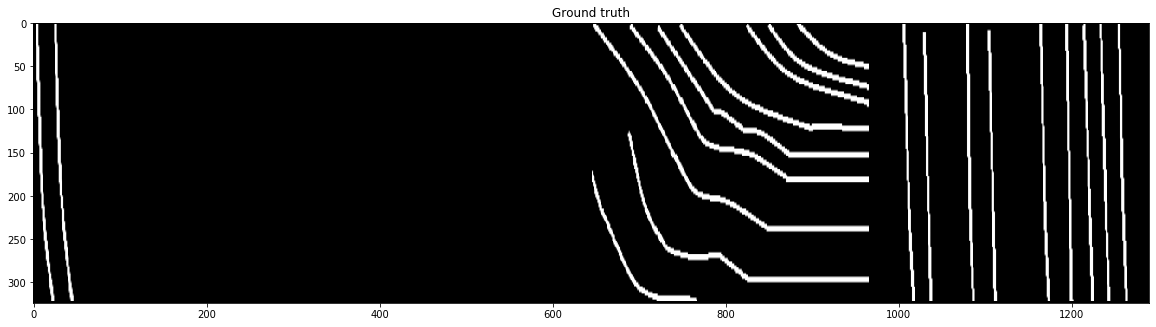

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


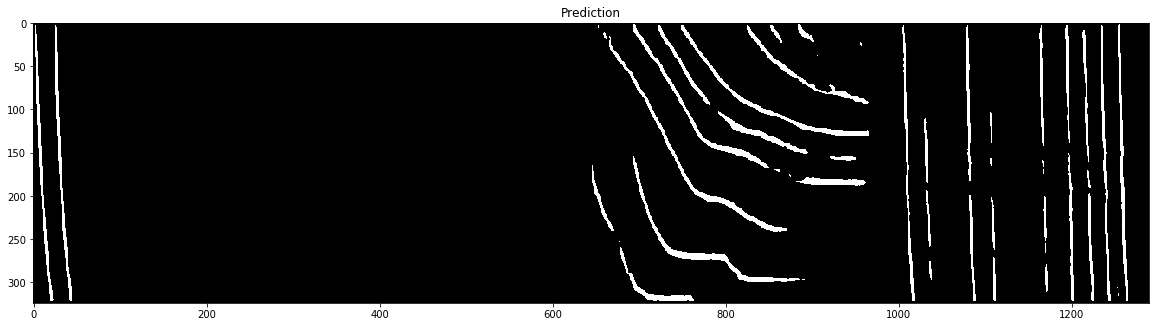

In [ ]:
dataiter = iter(test_data_loaders)
batch = dataiter.next()

f = plt.figure(figsize=(20, 20))
grid_img = make_grid(batch['mask'])
grid_img = grid_img.permute(1, 2, 0)
plt.imshow(grid_img)
plt.title('Ground truth')
plt.show()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = batch['image'].to(device)
prediction = model(inputs).detach().cpu()

prediction[prediction >= 0.1] = 1

f = plt.figure(figsize=(20, 20))
grid_img = make_grid(prediction)
grid_img = grid_img.permute(1, 2, 0)
plt.imshow(grid_img)
plt.title('Prediction')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


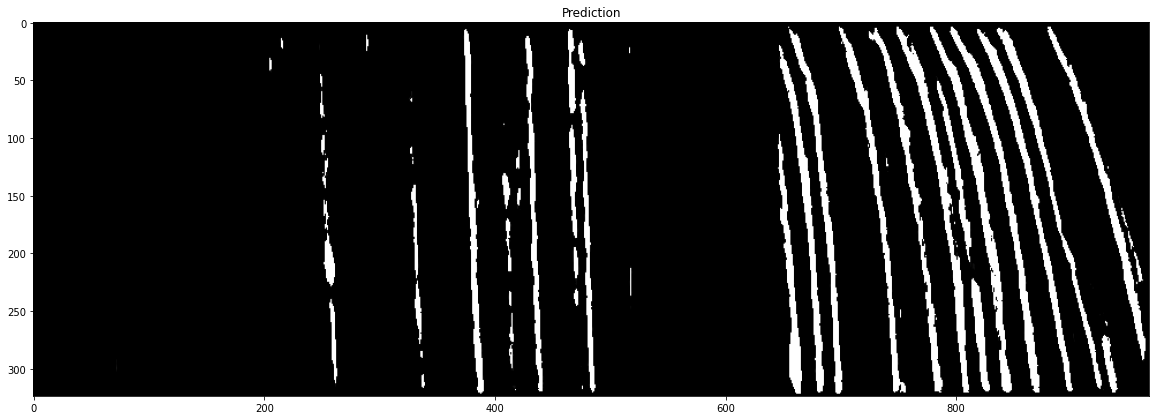

In [ ]:
prediction[prediction >= 0.5] = 1

f = plt.figure(figsize=(20, 20))
grid_img = make_grid(prediction)
grid_img = grid_img.permute(1, 2, 0)
plt.imshow(grid_img)
plt.title('Prediction')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

print(prediction[0][0].shape)
mask = prediction[0][0]

torch.Size([320, 320])


In [ ]:
print(mask.min(), mask.max())

tensor(-1.8941) tensor(1.)
